$$\large\textbf{Machine Learning para la predicción de la solubilidad}$$

$$\Large\textit{Jesus Alvarado-Huayhuaz}$$




_Cuaderno basado en https://github.com/dataprofessor_

## 1. Instalación

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh 
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh 
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local 
! conda install -c rdkit rdkit -y 
import sys 
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
! wget https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv

In [3]:
import pandas as pd
sol = pd.read_csv('delaney.csv')
sol

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.925,-4.377,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


In [4]:
# Para seleccionar solo una columna, por ejm SMILES
sol.SMILES

0                                    ClCC(Cl)(Cl)Cl
1                                      CC(Cl)(Cl)Cl
2                                    ClC(Cl)C(Cl)Cl
3                                        ClCC(Cl)Cl
4                               FC(F)(Cl)C(F)(Cl)Cl
                           ...                     
1139                   CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140          CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141         CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O 
1142    Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O
1143                         CNC(=O)Oc1cc(C)cc(C)c1
Name: SMILES, Length: 1144, dtype: object

In [7]:
# Para seleccionar solo una instancia de la columna:
sol.SMILES[4]

'FC(F)(Cl)C(F)(Cl)Cl'

In [18]:
# descriptor para 1 instancia
from rdkit import Chem
m = Chem.MolFromSmiles(sol.SMILES[4])
m.GetNumAtoms()

8

In [19]:
# para usar todas 
from rdkit import Chem
mol_list= []
for element in sol.SMILES:
  mol = Chem.MolFromSmiles(element)
  mol_list.append(mol)

# 2. Calcular descriptores moleculares
Ahora representaremos cada una de las moléculas del conjunto de datos mediante un conjunto de descriptores moleculares que se utilizarán para la construcción de modelos.

1. LogP (coeficiente de partición octanol-agua)
2. MW (peso molecular)
3. RB (Número de enlaces rotativos)
4. AP (proporción aromática = número de átomos aromáticos / número de átomos pesados)

Función personalizada denominada generate() para calcular los 3 descriptores LogP, MW y RB

In [10]:
import numpy as np
from rdkit.Chem import Descriptors
# Inspiración: https://codeocean.com/explore/capsules?query=tag:data-curation

def generate(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)
           
        row = np.array([desc_MolLogP,
                        desc_MolWt,
                        desc_NumRotatableBonds])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MolLogP","MolWt","NumRotatableBonds"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [11]:
df = generate(sol.SMILES)
df

,MolLogP,MolWt,NumRotatableBonds
0,2.59540,167.850,0.0
1,2.37650,133.405,0.0
2,2.59380,167.850,1.0
3,2.02890,133.405,1.0
4,2.91890,187.375,1.0
...,...,...,...
1139,1.98820,287.343,8.0
1140,3.42130,286.114,2.0
1141,3.60960,308.333,4.0
1142,2.56214,354.815,3.0


In [13]:
# Sobre el número de átomos aromáticos
SMILES = 'COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21'
m = Chem.MolFromSmiles(SMILES)
aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
aromatic_atoms
# False: no es un átomo aromático
# True: sí es un átomo aromático

[False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True]

In [15]:
def AromaticAtoms(m):
  aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  aa_count = []
  for i in aromatic_atoms:
    if i==True:
      aa_count.append(1)
  sum_aa_count = sum(aa_count)
  return sum_aa_count

In [17]:
# Aplicando al ejemplo con "m"
AromaticAtoms(m)

19

In [ ]:
# Aplicándole a todos, mediante iteración
desc_AromaticAtoms = [AromaticAtoms(element) for element in mol_list]
desc_AromaticAtoms

In [23]:
# Número de átomos pesados
SMILES = 'COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21'
m = Chem.MolFromSmiles(SMILES)
Descriptors.HeavyAtomCount(m)

34

In [ ]:
# Aplicándole a todos, mediante iteración
desc_HeavyAtomCount = [Descriptors.HeavyAtomCount(element) for element in mol_list]
desc_HeavyAtomCount

In [25]:
# Proporción aromática de "m"
SMILES = 'COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21'
m = Chem.MolFromSmiles(SMILES)
AromaticAtoms(m)/Descriptors.HeavyAtomCount(m)

0.5588235294117647

In [26]:
# Aplicándole a todos, mediante iteración
desc_AromaticProportion = [AromaticAtoms(element)/Descriptors.HeavyAtomCount(element) for element in mol_list]
df_desc_AromaticProportion = pd.DataFrame(desc_AromaticProportion)
df_desc_AromaticProportion

,0
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
1139,0.000000
1140,0.333333
1141,0.695652
1142,0.521739


# 3. Preparación del conjunto de datos: Matriz X

In [27]:
X = pd.concat([df,df_desc_AromaticProportion], axis=1)
X

,MolLogP,MolWt,NumRotatableBonds,0
0,2.59540,167.850,0.0,0.000000
1,2.37650,133.405,0.0,0.000000
2,2.59380,167.850,1.0,0.000000
3,2.02890,133.405,1.0,0.000000
4,2.91890,187.375,1.0,0.000000
...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000
1140,3.42130,286.114,2.0,0.333333
1141,3.60960,308.333,4.0,0.695652
1142,2.56214,354.815,3.0,0.521739


In [28]:
# Renombrando las columnas
X = X.rename(columns={'MolLogP':'MolLogP', 'MolWt':'MolWt', 'NumRotatableBonds':'NumRotatableBonds', 0:'AromaticProportion'})
X.columns

Index(['MolLogP', 'MolWt', 'NumRotatableBonds', 'AromaticProportion'], dtype='object')

In [29]:
X

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion
0,2.59540,167.850,0.0,0.000000
1,2.37650,133.405,0.0,0.000000
2,2.59380,167.850,1.0,0.000000
3,2.02890,133.405,1.0,0.000000
4,2.91890,187.375,1.0,0.000000
...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000
1140,3.42130,286.114,2.0,0.333333
1141,3.60960,308.333,4.0,0.695652
1142,2.56214,354.815,3.0,0.521739


# 4. Preparación del conjunto de datos: Matriz Y

In [30]:
sol.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [31]:
Y = sol.iloc[:,1]
Y

0      -2.180
1      -2.000
2      -1.740
3      -1.480
4      -3.040
        ...  
1139    1.144
1140   -4.925
1141   -3.893
1142   -3.790
1143   -2.581
Name: measured log(solubility:mol/L), Length: 1144, dtype: float64

Separando nuestros datos de entrenamiento y prueba

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [33]:
X_train

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion
351,0.42840,162.152,1.0,0.833333
1070,2.98410,134.222,0.0,0.600000
1043,2.35452,255.277,0.0,0.631579
661,1.73970,130.187,4.0,0.000000
973,1.30040,139.110,1.0,0.600000
...,...,...,...,...
32,2.61186,120.195,0.0,0.666667
142,4.66040,223.102,1.0,0.857143
776,3.01850,249.097,2.0,0.400000
646,1.85272,209.293,5.0,0.400000


In [34]:
Y_train

351    -0.910
1070   -3.660
1043   -3.043
661    -1.750
973    -0.740
        ...  
32     -3.400
142    -5.270
776    -3.592
646    -3.028
285    -2.730
Name: measured log(solubility:mol/L), Length: 915, dtype: float64

In [38]:
X_test

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion
491,2.86982,196.681,2.0,0.461538
1106,3.27520,148.249,1.0,0.545455
82,2.75270,98.189,4.0,0.000000
862,2.11840,121.183,2.0,0.666667
15,2.92028,134.222,0.0,0.600000
...,...,...,...,...
728,3.12560,184.242,3.0,0.857143
669,1.56890,166.176,2.0,0.500000
254,1.16730,88.150,2.0,0.000000
818,1.73970,130.187,4.0,0.000000


In [39]:
Y_test

491    -2.86
1106   -4.15
82     -3.73
862    -1.70
15     -4.59
        ... 
728    -2.92
669    -2.35
254    -0.29
818    -1.87
349    -6.57
Name: measured log(solubility:mol/L), Length: 229, dtype: float64

# 5. Modelo de regresión lineal

In [35]:
# Entrenamiento para RL
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

Predicción y métricas de logS de la data entrenada

In [36]:
Y_pred_train = model.predict(X_train)
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

Coefficients: [-0.74762301 -0.0064198   0.00474454 -0.39873098]
Intercept: 0.21869161604102283
Mean squared error (MSE): 1.03
Coefficient of determination (R^2): 0.77


Data de Test

In [40]:
Y_pred_test = model.predict(X_test)
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

Coefficients: [-0.74762301 -0.0064198   0.00474454 -0.39873098]
Intercept: 0.21869161604102283
Mean squared error (MSE): 0.91
Coefficient of determination (R^2): 0.79


# ECUACIONES

In [41]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [44]:
yintercept = '%.2f' % model.intercept_
LogP = '%.2f LogP' % model.coef_[0]
MW = '%.4f MW' % model.coef_[1]
RB = '%.4f RB' % model.coef_[2]
AP = '%.2f AP' % model.coef_[3]
print('LogS = ' + 
      ' ' + 
      yintercept + 
      ' + ' + 
      LogP + 
      ' +' + 
      MW + 
      ' + ' + 
      RB + 
      ' + ' + 
      AP)

LogS =  0.22 + -0.75 LogP +-0.0064 MW + 0.0047 RB + -0.40 AP


__Full data set__

In [48]:
# Usando nuestro dataset: x e Y, le llamaremos full
full = linear_model.LinearRegression()
full.fit(X, Y)

LinearRegression()

In [49]:
full_pred = model.predict(X)
print('Coefficients:', full.coef_)
print('Intercept:', full.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y, full_pred))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y, full_pred))

Coefficients: [-0.74173609 -0.00659927  0.00320051 -0.42316387]
Intercept: 0.2565006830997185
Mean squared error (MSE): 1.01
Coefficient of determination (R^2): 0.77


In [50]:
full_yintercept = '%.2f' % full.intercept_
full_LogP = '%.2f LogP' % full.coef_[0]
full_MW = '%.4f MW' % full.coef_[1]
full_RB = '+ %.4f RB' % full.coef_[2]
full_AP = '%.2f AP' % full.coef_[3]
print('LogS = ' + 
      ' ' + 
      full_yintercept + 
      ' ' + 
      full_LogP + 
      ' ' + 
      full_MW + 
      ' ' + 
      full_RB + 
      ' ' + 
      full_AP)

LogS =  0.26 -0.74 LogP -0.0066 MW + 0.0032 RB -0.42 AP


# __Predicción vs Experimental__

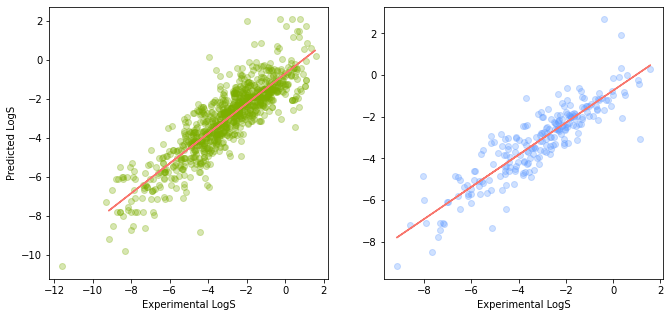

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(11,5))

# 1 row, 2 column, plot 1
plt.subplot(1, 2, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=0.3)

z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

# 1 row, 2 column, plot 2
plt.subplot(1, 2, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=0.3)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.xlabel('Experimental LogS')

#Guardando la gráfica
#plt.savefig('plot_horizontal_logS.png')
#plt.savefig('plot_horizontal_logS.pdf')
plt.show()

Delaney:
__LogS = 0.16 - 0.63 cLogP - 0.0062 MW + 0.066 RB - 0.74 AP__

Pat Walters:
__LogS = 0.26 - 0.74 LogP - 0.0066 MW + 0.0034 RB - 0.42 AP__

TutoBas Train set:
__LogS =  0.26 - 0.73 LogP - 0.0069 MW 0.0163 RB - 0.36 AP__

Full dataset
__LogS =  0.26 - 0.74 LogP - 0.0066 MW + 0.0032 RB - 0.42 AP__